<IPython.core.display.Javascript object>


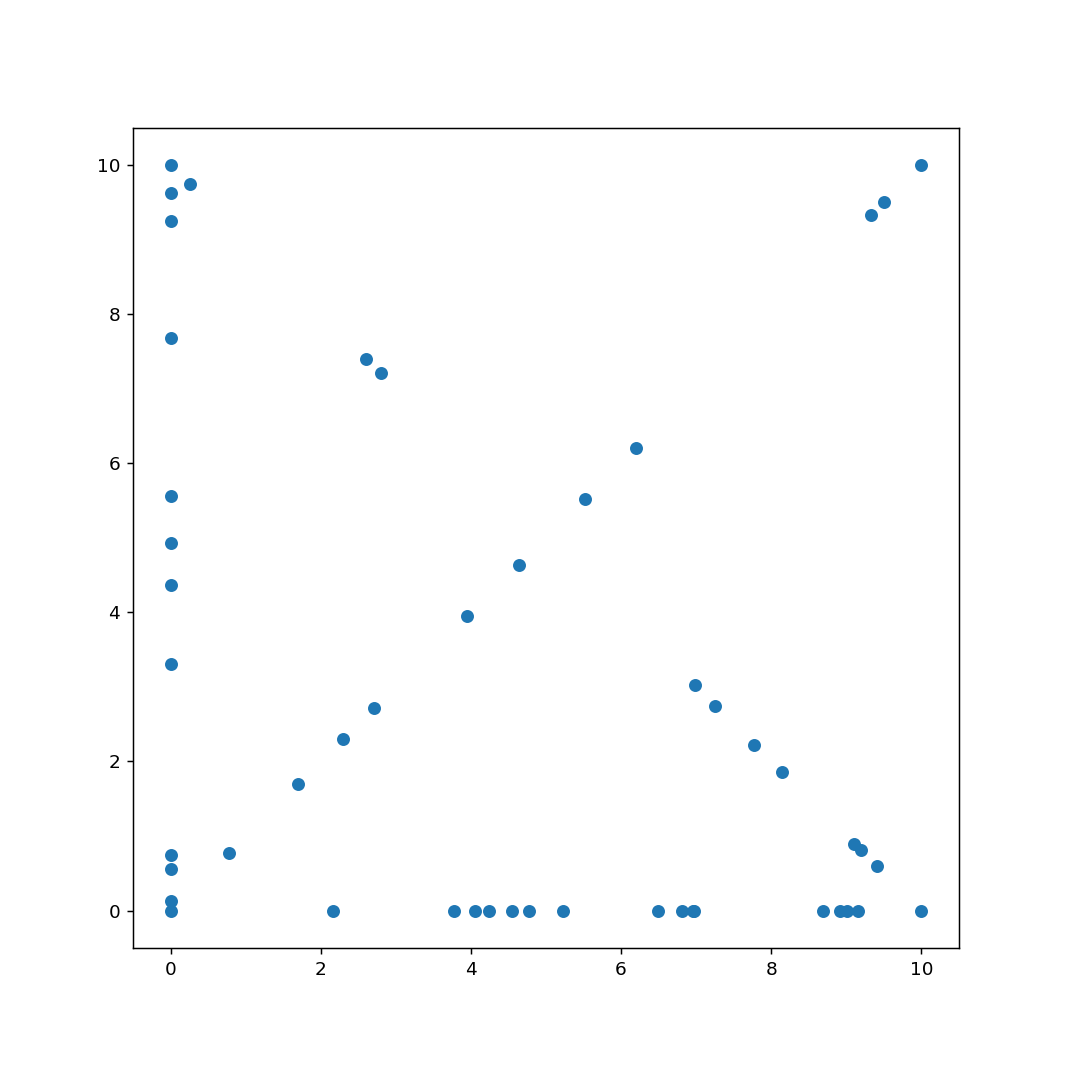

In [2]:
# importy podstawowych bibliotek i ustawienie seeda, w celu powtarzalności wyników
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib notebook
import time
np.random.seed(42)

# w generatorach punkt jest opisywany przez współrzędną x, y oraz ID punktu czyli trzecia współrzędna punktu

# generujemy dane z zestawu a) n danych z rozkładu jednostajnego z zadanego przedziału
def generator1(n = 100, x_min = -100, x_max = 100, y_min = -100, y_max = 100):
    rand1x = np.random.uniform(x_min, x_max, n)
    rand1y = np.random.uniform(y_min, y_max, n)
    rand1_idx = range(n)
    return list(zip(rand1x, rand1y, rand1_idx))

# generujemy dane z zestawu b) punkty leżące na okręgu
def generator2(n = 100, R = 10, x_center = 0, y_center = 0):
    rand2 = list()
    for i in range(n):
        alpha = np.random.uniform(0, math.pi*2)
        x = R * math.sin(alpha) + x_center
        y = R * math.cos(alpha) + y_center
        rand2.append((x, y, i))
    return rand2

# generujemy dane z zestawu c) punkty leżące na bokach prostokąta 
def generator3(n = 100, x_max = 10, x_min = -10, y_max = 10, y_min = -10):
    rand3 = list()
    for i in range(n):
        side_idx = np.random.randint(0, 4)
        if side_idx == 0: # górny bok
            y = y_max
            x = np.random.uniform(x_min, x_max)
            rand3.append((x, y, i))
        elif side_idx == 1: # dolny bok
            y = y_min
            x = np.random.uniform(x_min, x_max)
            rand3.append((x, y, i))
        elif side_idx == 2: # prawy bok
            x = x_max
            y = np.random.uniform(y_min, y_max)
            rand3.append((x, y, i))
        else: # lewy bok
            x = x_min
            y = np.random.uniform(y_min, y_max)
            rand3.append((x, y, i))
    return rand3

#generujemy dane z zestawu d), punkty leżące na bokach kwadratu, które leżą na osiach układu oraz na przekątnych
#wraz z rogami kwadratu
def generator4(n_axis = 25, n_diag = 20, upper_right = 10):
    rand4 = list() #najpierw dane z osi, potem przekątne
    for i in range(n_axis):
        side_idx = np.random.choice(2)
        if side_idx == 0: # oś OX
            y = 0
            x = np.random.uniform(0, upper_right)
            rand4.append((x, y, i))
        else: # oś OY
            x = 0
            y = np.random.uniform(0, upper_right)
            rand4.append((x, y, i))
    for i in range(n_diag):
        diag_idx = np.random.choice(2)
        if diag_idx == 0: # przekątna łącząca punkty (0, upper_right) oraz (upper_right, 0)
            x = np.random.uniform(0, upper_right)
            y = -x + upper_right
            rand4.append((x, y, i + n_axis))
        else: # druga z przekątnych
            x = np.random.uniform(0, upper_right)
            y = x
            rand4.append((x, y, i + n_axis))
    rand4.append((0, upper_right, n_axis+n_diag))
    rand4.append((0, 0, n_axis+n_diag+1))
    rand4.append((upper_right, upper_right, n_axis+n_diag+2))
    rand4.append((upper_right, 0, n_axis+n_diag+3))
    return rand4

gen1 = generator1()
gen2 = generator2()
gen3 = generator3()
gen4 = generator4()

#ta część służy do wizualizacji wygenerowanych punktów
plt.figure(figsize=(6,6))
x, y, z = list(zip(*gen4))
plt.scatter(x, y)
x_y = list(zip(x, y))

In [14]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [15]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


In [16]:
# funkcja obliczająca iloczyn wektorowy dwóch wektorów AB x AC jeśli A(a_x, a_y), B(b_x, B_y), C(c_x, c_y) 
def vec_prod(a_x, a_y, b_x, b_y, c_x, c_y): # w dwóch wymiarach
    return (b_x - a_x) * (c_y - a_y) - (c_x - a_x) * (b_y - a_y)

#właściwy alogrytm Jarvisa
def Jarvis_algorithm(points):
    t0 = time.time() # włączamy licznik czasu
    min_y = min_x = float("inf")
    min_idx = max_idx = -1
    #tutaj odbywa się wyszukiwania punktu o minimalnej współrzędnej y, w razie remisów o minimalnej współrzędnej x
    for point in points:
        if point[1] == min_y:
            if point[0] < min_x:
                min_x = point[0]
                min_idx = point[2]
        elif point[1] < min_y:
            min_y = point[1]
            min_x = point[0]
            min_idx = point[2]
    
    #p0 to punkt początkowy, wyszkukiwany powyżej
    p0 = points[min_idx]
    curr_point = p0
    result = [points[min_idx]]
    
    #counter to rodzaj flagi, żeby pętla while skończyła się po tym jak drugi raz curr_point będzie p0
    counter = 0 
    while curr_point != p0 or counter == 0:
        min_angle_pos_y = p0[1]
        min_angle_pos_x = p0[0]
        min_angle_idx = p0[2]
        for point in points:
            if point != curr_point:
                if vec_prod(curr_point[0], curr_point[1], min_angle_pos_x, \
                              min_angle_pos_y, point[0], point[1]) < -10 ** -18:
                    min_angle_pos_x = point[0]
                    min_angle_pos_y = point[1]
                    min_angle_idx = point[2]
                if (abs(vec_prod(curr_point[0], curr_point[1], min_angle_pos_x, \
                            min_angle_pos_y, point[0], point[1])) < 10 ** -18) and \
                    (math.sqrt((curr_point[0] - min_angle_pos_x)**2 + (curr_point[1] - min_angle_pos_y)**2) \
                    < math.sqrt((curr_point[0] - point[0])**2 + (curr_point[1] - point[1])**2)):
                        min_angle_pos_x = point[0]
                        min_angle_pos_y = point[1]
                        min_angle_idx = point[2]
        result.append(points[min_angle_idx])
        curr_point = points[min_angle_idx]
        counter += 1
        t1 = time.time() - t0
    print("time Jarvis", t1)
    return result[:len(result)-1] # to slicowanie jest po to, żeby nie dodawać dwa razy 
                                                        # punktu pierwszego 
#generuje dane do plotowania poniżej
points = generator3()
x1, y1, z1 = list(zip(*points))
result = Jarvis_algorithm(points)
x2, y2, z2 = list(zip(*result))
to_plot = []
for i in range(len(points)):
    if i in z2:
        to_plot.append("otoczka")
    else:
        to_plot.append("poza")

time Jarvis 0.0007374286651611328


<IPython.core.display.Javascript object>


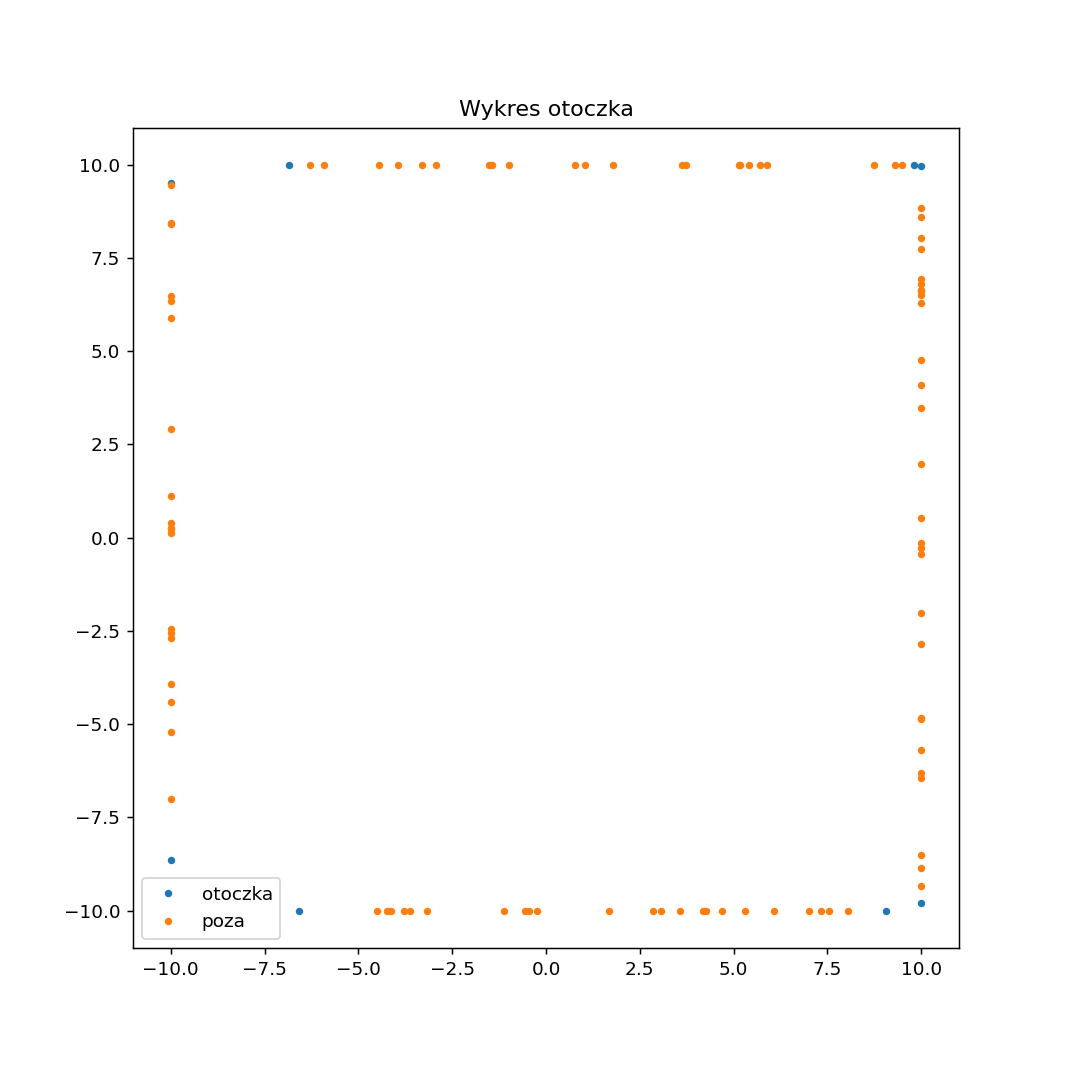

In [10]:
#roboczy wykres, właściwy jest poniżej
#blok służący do rysowania otoczek, głównie służył mi do oceny poprawności algorytmów w trakcie pisania

plt.figure(figsize=(6,6))
data = pd.DataFrame({"X value": x1, "Y value": y1, "orientation1":to_plot})
groups = data.groupby("orientation1")

for name, group in groups:

    plt.plot(group["X value"], group["Y value"],'.', label=name)
    plt.title('Wykres otoczka')
    
plt.legend()

In [11]:
# QuickSort do algorytmu Grahama, operator porównania, to iloczyn wektorowy, zaś w następnej kolejności odległość pkt od siebie
def partition(array, start, end, p0):
        pivot = array[start]
        low = start + 1
        high = end
        
        while True:
            while low <= high and ((vec_prod(p0[0], p0[1], pivot[0], pivot[1], array[high][0], array[high][1]) > 10 ** -18) \
                    or (abs(vec_prod(p0[0], p0[1], pivot[0], pivot[1], array[high][0], array[high][1])) < 10 ** -18 \
                    and math.sqrt((p0[0]-pivot[0]) ** 2 + (p0[1] - pivot[1]) ** 2) \
                    < math.sqrt((p0[0]-array[high][0]) ** 2 + (p0[1] - array[high][1]) ** 2))):
                high = high - 1
            while low <= high and ((vec_prod(p0[0], p0[1], pivot[0], pivot[1], array[low][0], array[low][1]) < -10 ** -18) \
                    or ((vec_prod(p0[0], p0[1], pivot[0], pivot[1], array[low][0], array[low][1])) < 10 ** -18 \
                    and math.sqrt((p0[0]-pivot[0]) ** 2 + (p0[1] - pivot[1]) ** 2) \
                    > math.sqrt((p0[0]-array[low][0])** 2 + (p0[1] - array[low][1]) ** 2))):
                low = low + 1
            if low <= high:
                array[low], array[high] = array[high], array[low]
            else:
                break

        array[start], array[high] = array[high], array[start]

        return high

def quick_sort(array, start, end, p0):
    if start >= end:
            return

    p = partition(array, start, end, p0)
    quick_sort(array, start, p-1, p0)
    quick_sort(array, p+1, end, p0)


def Graham_algorithm(points):
    x1, y1, z1 = list(zip(*points))
    points_xy = list(zip(x1, y1))
    t0 = time.time()
    min_y = min_x = float("inf")
    #min_x = float("inf")
    min_idx = -1
    for point in points:
        if point[1] == min_y:
            if point[0] < min_x:
                min_x = point[0]
                min_idx = point[2]
        elif point[1] < min_y:
            min_y = point[1]
            min_x = point[0]
            min_idx = point[2]
    p0 = points[min_idx]
    sorted_points = quick_sort(points, 0, len(points) - 1, p0)
    stack = []
    for i in range(3):
        stack.append(points[i])
    # przypadek w którym dokładnie trzy punkty początkowe leżałyby na jednej prostej wzdłuż osi OX
    # jest to jedyny przypadek, którego musze się pozbyć osobno, ponieważ przy moim warunku nie wyleciałby
    # one ze stacka, więc wtedy dostawałbym zawsze 1 naddatkowy punkt do otoczki
    if abs(vec_prod(stack[0][0], stack[0][1], stack[1][0], stack[1][1], stack[2][0], stack[2][1])) < 10 ** -18:
        del stack[1]
    for point in points[3:]:
        while vec_prod(stack[-1][0],stack[-1][1], stack[-2][0], stack[-2][1], point[0], point[1]) >= 0:
            del stack[-1]
            if len(stack) == 1:
                break
        stack.append(point)
    t1 = time.time() - t0
    print("time Graham ", t1)
    return stack
        
#wyznaczamy otoczkę dla zestawu points        
points = generator4(n_axis = 498, n_diag = 498) 
x1, y1, z1 = list(zip(*points))
hull = Graham_algorithm(points)
#print(len(hull))

# wyznacza właściwą liste indeksów
vertex_list = []
for i in range(len(hull)):
    vertex_list.append(hull[i][2])

# to przydaje się do plotowania powyżej
result = []
for i in range(len(hull)):
    result.append(hull[i][2])
to_plot = []
for i in range(len(points)):
    if i in result:
        to_plot.append("otoczka")
    else:
        to_plot.append("poza") 



time Graham  0.018465042114257812


<IPython.core.display.Javascript object>


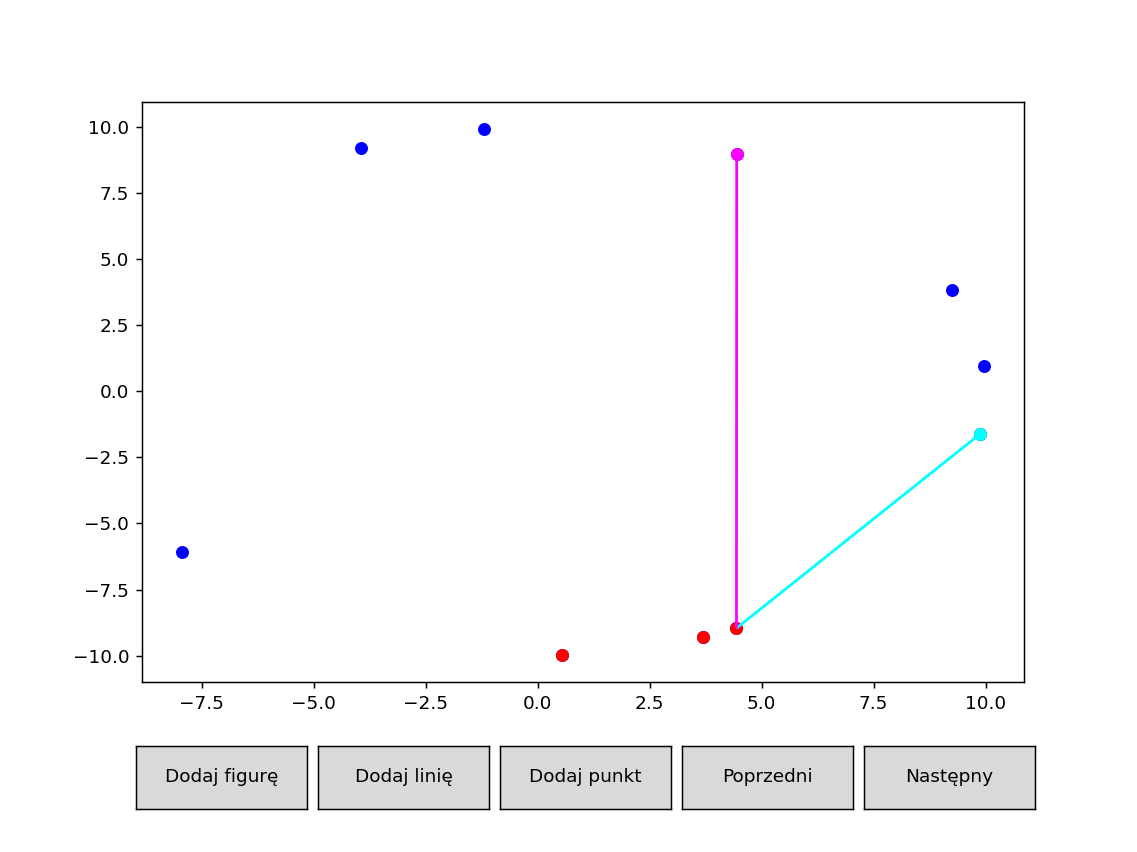

In [20]:
# Jarvis do wykresów
#funkcje pomocnicze do wykonywania wykresu
def prepareResult(points_xy, plot, linesList, result) :
    point1=result.pop()
    point2=result.pop()
    linesList.append((point1, point2))
    result.append(point2)
    result.append(point1)
    copyResult = Copy_points_xy(result)
    linesListCopy = linesList.copy()
    plot.append(Scene([PointsCollection(points = points_xy, color = 'blue'), 
                                PointsCollection(copyResult, color = 'red')], 
                      [LinesCollection(linesListCopy, color = 'green')]))
    
def Copy_points_xy(points):
    result = []
    for point in points:
        result.append((point[0], point[1]))
    return result

def to_lines(points_xy):
    result = []
    n = len(points_xy)
    for i in range(n-1):
        result.append([(points_xy[i][0], points_xy[i][1]),(points_xy[i+1][0], points_xy[i+1][1])])
    result.append([(points_xy[n-1][0], points_xy[n-1][1]), (points_xy[0][0], points_xy[0][1])])
    return result

#Algorytm Jarvis do plotowania
def Jarvis_algorithm_plot(points):
    min_y = min_x = max_x = float("inf")
    min_idx = max_idx = -1
    max_y = -float("inf")
    for point in points:
        if point[1] == min_y:
            if point[0] < min_x:
                min_x = point[0]
                min_idx = point[2]
        elif point[1] < min_y:
            min_y = point[1]
            min_x = point[0]
            min_idx = point[2]
            
    points_xy = Copy_points_xy(points)  
    # p0 to punkt startowy
    p0 = points[min_idx]
    curr_point = p0
    result = [points[min_idx]]
    
    plot = [Scene([PointsCollection(points_xy, color = 'blue')])]
    plot.append(Scene([PointsCollection(points_xy, color = 'blue'), 
                       PointsCollection([(result[0][0],result[0][1]) ], color = 'red')]))
    linesList=[]
    counter = 0 
    while curr_point != p0 or counter == 0:
        #na początku ustawiamy minimalny pod względem współrzędnej kątowej punkt na punkt p0
        min_angle_pos_y = p0[1]
        min_angle_pos_x = p0[0]
        min_angle_idx = p0[2]
        for point in points:
            if point != curr_point:
                copyResult = Copy_points_xy(result)
                linesListCopy = linesList.copy()
                plot.append(Scene([PointsCollection(points_xy, color = 'blue'), 
                                            PointsCollection(copyResult, color = 'red'),
                                            PointsCollection([(min_angle_pos_x, min_angle_pos_y)], color = 'cyan'), 
                                            PointsCollection(points = [(point[0], point[1])], color = 'magenta')],
                        [LinesCollection(linesListCopy, color = 'blue'), 
                        LinesCollection([(copyResult[len(copyResult) - 1], (min_angle_pos_x, min_angle_pos_y))], color = 'cyan'), 
                        LinesCollection([(copyResult[len(copyResult) - 1], (point[0], point[1]))], color = 'magenta')]))
                # jeśli punkt albo ma min współrzędną kątową, albo taką samą, lecz położony dalej
                if ((vec_prod(curr_point[0], curr_point[1], min_angle_pos_x, \
                            min_angle_pos_y, point[0], point[1]) == 0)
                    and (math.sqrt((curr_point[0] - min_angle_pos_x)**2 + (curr_point[1] - min_angle_pos_y)**2) \
                    < math.sqrt((curr_point[0] - point[0])**2 + (curr_point[1] - point[1])**2))) or vec_prod(curr_point[0], curr_point[1], min_angle_pos_x, \
                              min_angle_pos_y, point[0], point[1]) < 0:
                        #aktualizuj punkt min
                        min_angle_pos_x = point[0]
                        min_angle_pos_y = point[1]
                        min_angle_idx = point[2]
                        
                        copyResult = Copy_points_xy(result)
                        linesListCopy = linesList.copy()
                        plot.append(Scene([PointsCollection(points_xy, color = 'blue'),
                                                PointsCollection(copyResult, color = 'red'),
                                                PointsCollection(points = [(point[0], point[1])], color = 'magenta'),
                                                PointsCollection(points = [(min_angle_pos_x, min_angle_pos_y)], color = 'cyan')], 
                            [LinesCollection(linesListCopy, color = 'blue'),
                            LinesCollection([(copyResult[len(copyResult) - 1], (point[0], point[1]))], color = 'magenta'),
                            LinesCollection([(copyResult[len(copyResult) - 1], (point[0], point[1]))], color = 'cyan')]))
                        
        result.append(points[min_angle_idx])
        curr_point = points[min_angle_idx]
        counter += 1
        
    prepareResult(points_xy, plot, linesList, result)
    return result, plot

#generujemy wyniki oraz zestawy punktów wygodne do użycia
points2 = generator2(10)
points_xy = Copy_points_xy(points2)
result , plot = Jarvis_algorithm_plot(points2)
result_xy = Copy_points_xy(result)
# na końcu dodajemy otoczkę wraz z krawędziami
plot.append(Scene([PointsCollection(points_xy, color = 'blue'), PointsCollection(result_xy, color = 'red')], [LinesCollection(to_lines(result_xy))]))
plt1 = Plot(scenes = plot)
plt1.draw()

<IPython.core.display.Javascript object>


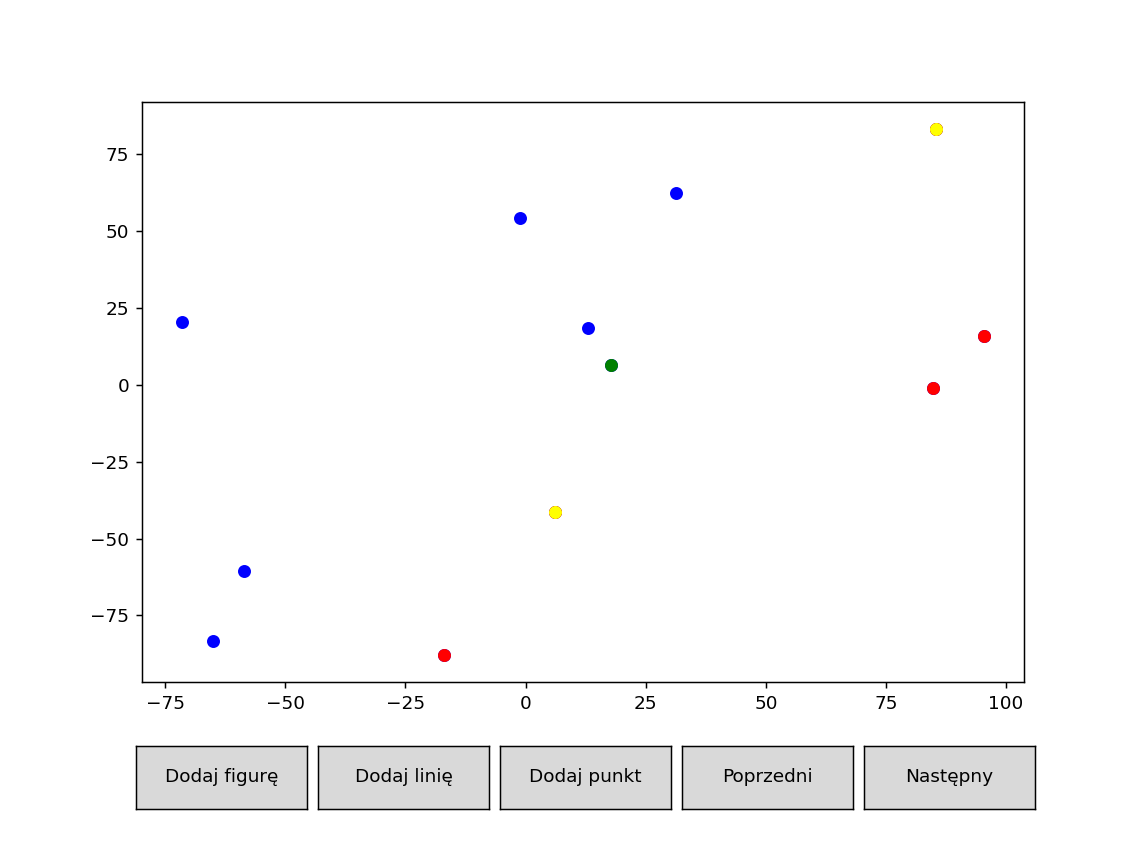

In [21]:
#kopia Grahama do wykresów

# QuickSort do algorytmu Grahama, operator porównania, to iloczyn wektorowy, zaś w następnej kolejności odległość pkt od siebie
def partition(array, start, end, p0):
        pivot = array[start]
        low = start + 1
        high = end
        
        while True:
            while low <= high and ((vec_prod(p0[0], p0[1], pivot[0], pivot[1], array[high][0], array[high][1]) > 10 ** -18) \
                    or (abs(vec_prod(p0[0], p0[1], pivot[0], pivot[1], array[high][0], array[high][1])) < 10 ** -18 \
                    and math.sqrt((p0[0]-pivot[0]) ** 2 + (p0[1] - pivot[1]) ** 2) \
                    < math.sqrt((p0[0]-array[high][0]) ** 2 + (p0[1] - array[high][1]) ** 2))):
                high = high - 1
            while low <= high and ((vec_prod(p0[0], p0[1], pivot[0], pivot[1], array[low][0], array[low][1]) < -10 ** -18) \
                    or ((vec_prod(p0[0], p0[1], pivot[0], pivot[1], array[low][0], array[low][1])) < 10 ** -18 \
                    and math.sqrt((p0[0]-pivot[0]) ** 2 + (p0[1] - pivot[1]) ** 2) \
                    > math.sqrt((p0[0]-array[low][0])** 2 + (p0[1] - array[low][1]) ** 2))):
                low = low + 1
            if low <= high:
                array[low], array[high] = array[high], array[low]
            else:
                break

        array[start], array[high] = array[high], array[start]

        return high


def quick_sort(array, start, end, p0):
    if start >= end:
            return

    p = partition(array, start, end, p0)
    quick_sort(array, start, p-1, p0)
    quick_sort(array, p+1, end, p0)

#Funckje pomocnicze do Algorytmu Grahama    
    
def Copy_points_xy(points):
    result = []
    for point in points:
        result.append((point[0], point[1]))
    return result

def to_lines(points_xy):
    result = []
    n = len(points_xy)
    for i in range(n-1):
        result.append([(points_xy[i][0], points_xy[i][1]),(points_xy[i+1][0], points_xy[i+1][1])])
    result.append([(points_xy[n-1][0], points_xy[n-1][1]), (points_xy[0][0], points_xy[0][1])])
    return result
    
def Graham_algorithm_plot(points):
    x1, y1, z1 = list(zip(*points))
    points_xy = list(zip(x1, y1))
    min_y = min_x = float("inf")
    min_idx = -1
    for point in points:
        if point[1] == min_y:
            if point[0] < min_x:
                min_x = point[0]
                min_idx = point[2]
        elif point[1] < min_y:
            min_y = point[1]
            min_x = point[0]
            min_idx = point[2]
    p0 = points[min_idx]
    sorted_points = quick_sort(points, 0, len(points) - 1, p0)
    stack = []
    sceneList = [Scene([PointsCollection(points_xy, color = 'blue')])]
    for i in range(3):
        stack.append(points[i])
    if abs(vec_prod(stack[0][0], stack[0][1], stack[1][0], stack[1][1], stack[2][0], stack[2][1])) < 10 ** -18:
        del stack[1]
    for point in points[3:]:
        stack_copy = Copy_points_xy(stack)
        sceneList.append(Scene([PointsCollection(points_xy, color = 'blue'), PointsCollection(stack_copy, color = 'red')]))
        
        while vec_prod(stack[-1][0],stack[-1][1], stack[-2][0], stack[-2][1], point[0], point[1]) >= 0:
            sceneList.append(Scene([PointsCollection(points_xy, color = 'blue'), PointsCollection(stack_copy, color = 'red'),
                PointsCollection([(point[0], point[1])], color = 'green'), 
                PointsCollection([(stack_copy[-1][0], stack_copy[-1][1]), (stack_copy[-2][0], stack_copy[-2][1])], color = 'yellow')]))
            del stack[-1]
            if len(stack) == 1:
                break
        stack.append(point)
    final = Copy_points_xy(stack)
    sceneList.append(Scene([PointsCollection(points_xy, color = 'blue'), PointsCollection(final, color = 'red')],
                           [LinesCollection(to_lines(final), color = 'green')]))
    return stack, sceneList
        
        
points = generator1(12)
x1, y1, z1 = list(zip(*points))
hull, sceneList = Graham_algorithm_plot(points)


plot=Plot(scenes = sceneList)
plot.draw()
